In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from torchsummary import summary
from torch.optim import Adam

In [2]:
SEED = 1
torch.manual_seed(SEED)

In [3]:
data = pd.read_csv('startup.csv')
data.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [4]:
data['State'].value_counts()

California    17
New York      17
Florida       16
Name: State, dtype: int64

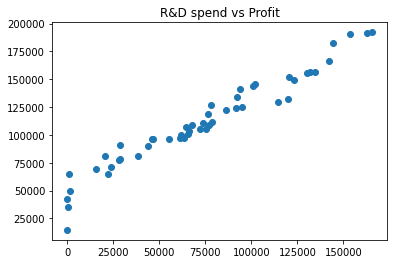

In [5]:
import matplotlib.pyplot as plt
plt.title('R&D spend vs Profit')
plt.scatter(x = data['R&D Spend'], y = data['Profit'])
plt.show()

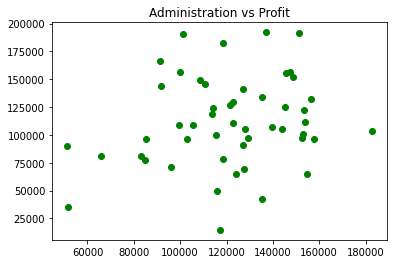

In [6]:
plt.title('Administration vs Profit')
plt.scatter(x = data['Administration'], y = data['Profit'], c = 'green')
plt.show()

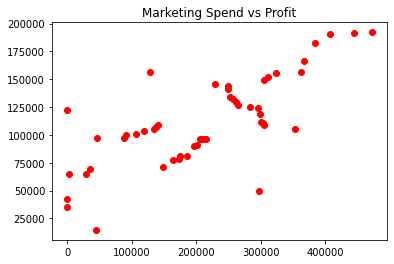

In [7]:
plt.title('Marketing Spend vs Profit')
plt.scatter(x = data['Marketing Spend'], y = data['Profit'], c = 'red')
plt.show()

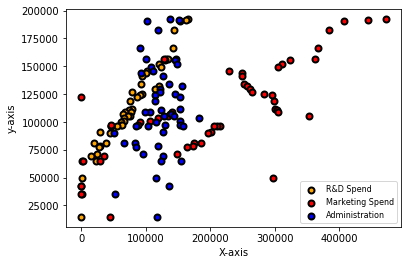

In [8]:
x1 = plt.scatter(x = data['R&D Spend'], y = data['Profit'], c = 'orange', 
            linewidths = 2,   
            edgecolor = 'black')

x2 = plt.scatter(x = data['Marketing Spend'], y = data['Profit'], c = 'red', 
            linewidths = 2,   
            edgecolor = 'black')

x3 = plt.scatter(x = data['Administration'], y = data['Profit'], c = 'blue', 
           linewidth = 2,
           edgecolor = 'black')

plt.legend((x1, x2, x3), ('R&D Spend', 'Marketing Spend', 'Administration'), loc = 'lower right', fontsize = 8)
plt.xlabel('X-axis')
plt.ylabel('y-axis')
plt.show()

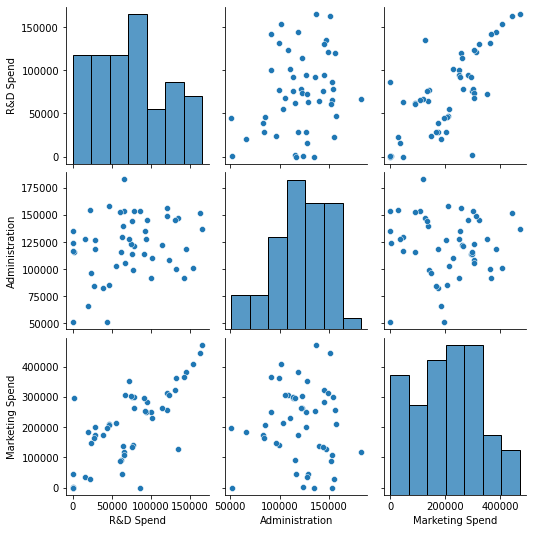

In [9]:
import seaborn as sns
data1 = data.copy()
data1 = data1.drop(['State', 'Profit'], axis = 1)
sns.pairplot(data1)

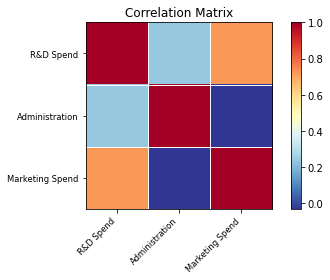

In [10]:
import statsmodels
from statsmodels.graphics.correlation import plot_corr
corr = data1.corr()
fig = plot_corr(corr, xnames = corr.columns)

In [11]:
X = data.drop(['Profit'], axis = 1)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [3])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [14]:
y = data[['Profit']].values
y1 = data['Profit'].values

In [16]:
print(y.shape)
print(y1.shape)

(50, 1)
(50,)


In [12]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15
SHUFFLE = True

In [13]:
def split(X, y, val_size, test_size, shuffle):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, shuffle = shuffle)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = val_size, shuffle = shuffle)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [14]:
X_train, X_val, X_test, y_train, y_val, y_test = split(X, y, VAL_SIZE, TEST_SIZE, SHUFFLE)

In [15]:
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_test: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (35, 6), y_train: (35, 1)
X_val: (7, 6), y_test: (7, 1)
X_test: (8, 6), y_test: (8, 1)


In [16]:
x_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

In [17]:
# Apply scaler on training and test data
X_train = x_scaler.transform(X_train)
y_train = y_scaler.transform(y_train).ravel().reshape(-1, 1)
X_val = x_scaler.transform(X_val)
y_val = y_scaler.transform(y_val).ravel().reshape(-1, 1)
X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test).ravel().reshape(-1, 1)

In [18]:
INPUT_DIM = X_train.shape[1] # X is 1-dimensional
OUTPUT_DIM = y_train.shape[1] # y is 1-dimensional

In [19]:
from torch import nn

In [20]:
class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, output_dim)
        
    def forward(self, x_in):
        y_pred = self.fc1(x_in)
        return y_pred

In [21]:
# Initialize model
model = LinearRegression(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM)
print (model.named_parameters)
summary(model, input_size=(INPUT_DIM,)) # -1 is the batch size

<bound method Module.named_parameters of LinearRegression(
  (fc1): Linear(in_features=6, out_features=1, bias=True)
)>
Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            7
Total params: 7
Trainable params: 7
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            7
Total params: 7
Trainable params: 7
Non-trainable params: 0

In [22]:
loss_fn = nn.MSELoss()

In [23]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1) 

In [24]:
# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

In [25]:
# Training
NUM_EPOCHS = 100
for epoch in range(NUM_EPOCHS):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()
    
    if epoch%20==0: 
        print (f"Epoch: {epoch} | loss: {loss:.2f}")

Epoch: 0 | loss: 0.90
Epoch: 20 | loss: 0.07
Epoch: 40 | loss: 0.07
Epoch: 60 | loss: 0.06
Epoch: 80 | loss: 0.06


In [26]:
# Predictions
pred_train = model(X_train)
pred_test = model(X_test)

In [27]:
# Performance
train_error = loss_fn(pred_train, y_train)
test_error = loss_fn(pred_test, y_test)
print(f'train_error: {train_error:.2f}')
print(f'test_error: {test_error:.2f}')

train_error: 0.06
test_error: 0.03


In [28]:
from sklearn.metrics import r2_score
# r2 = r2_score(y_test, pred_test)
# print(f'r2 square for the model is : {r2}')
# This gives the below error.
# Note : RuntimeError --> Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.
y_test = y_test.detach().numpy()
pred_test = pred_test.detach().numpy()

In [29]:
r2 = r2_score(y_test, pred_test)
print(f'{r2*100:.2f}% of changeability of the dependent output can be explained by the model.')

95.66% of changeability of the dependent output can be explained by the model.


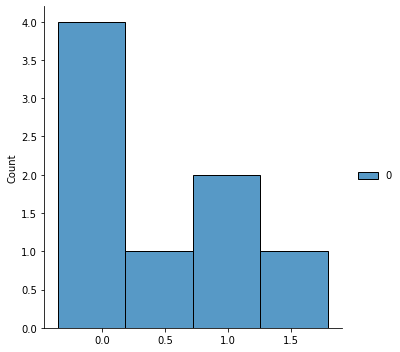

In [30]:
sns.displot(y_test)

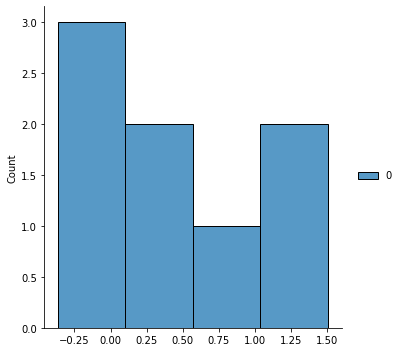

In [31]:
sns.displot(pred_test)

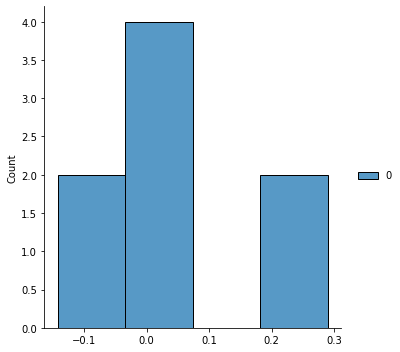

In [32]:
import seaborn as sns
sns.displot(y_test - pred_test)